<a href="https://colab.research.google.com/github/Agrave1/NFL_Scores/blob/main/Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
betting_df = pd.read_csv("/content/drive/MyDrive/Project 2/Spread_Scores.csv")
betting_df.head()

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,total_score,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail
0,9/2/1966,1966,1,False,Miami Dolphins,14.0,23.0,37,Oakland Raiders,NaN,NaN,NaN,Orange Bowl,False,83.0,6.0,71.0,NaN
1,9/3/1966,1966,1,False,Houston Oilers,45.0,7.0,52,Denver Broncos,NaN,NaN,NaN,Rice Stadium,False,81.0,7.0,70.0,NaN
2,9/4/1966,1966,1,False,San Diego Chargers,27.0,7.0,34,Buffalo Bills,NaN,NaN,NaN,Balboa Stadium,False,70.0,7.0,82.0,NaN
3,9/9/1966,1966,2,False,Miami Dolphins,14.0,19.0,33,New York Jets,NaN,NaN,NaN,Orange Bowl,False,82.0,11.0,78.0,NaN
4,9/10/1966,1966,1,False,Green Bay Packers,24.0,3.0,27,Baltimore Colts,NaN,NaN,NaN,Lambeau Field,False,64.0,8.0,62.0,NaN


## Data Cleaning

In [28]:
betting_df.duplicated().sum()

0

In [29]:
betting_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13232 entries, 0 to 13231
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   schedule_date        13232 non-null  object 
 1   schedule_season      13232 non-null  int64  
 2   schedule_week        13232 non-null  object 
 3   schedule_playoff     13232 non-null  bool   
 4   team_home            13232 non-null  object 
 5   score_home           13231 non-null  float64
 6   score_away           13231 non-null  float64
 7   total_score          13232 non-null  int64  
 8   team_away            13232 non-null  object 
 9   team_favorite_id     10753 non-null  object 
 10  spread_favorite      10753 non-null  float64
 11  over_under_line      10743 non-null  object 
 12  stadium              13232 non-null  object 
 13  stadium_neutral      13232 non-null  bool   
 14  weather_temperature  12189 non-null  float64
 15  weather_wind_mph     12172 non-null 

In [30]:
betting_df = betting_df.drop(labels = range(0, 2500), axis = 0)
#Dropped those rows because all the missing values were at the start of the dataset
#Didn't impute because these betting statistics can't be imputed or they would skew the results for the games with accurate betting data

In [31]:
betting_df["schedule_week"].replace({"SuperBowl" : "Superbowl", "WildCard" : "Wildcard"}, inplace = True)
betting_df["schedule_week"].value_counts()
#Fixed inconsistencies in the naming of object data

16            649
15            649
1             647
2             647
13            645
14            644
12            641
11            625
3             598
10            589
9             572
4             572
7             569
8             567
5             560
6             557
17            509
Division      172
Wildcard      160
Conference     86
Superbowl      44
18             30
Name: schedule_week, dtype: int64

In [32]:
betting_df["score_home"].fillna(23, inplace = True)
betting_df["score_away"].fillna(20, inplace = True)
#Filled in missing values for Superbowl 2021 season with correct score after google searching

In [33]:
betting_df = betting_df.drop(columns = ["weather_detail"])
#Too many categorical values and too many missing values to input based on most frequent
#Most frequent was dome and many stadiums and games would be incorrectly classified as dome if imputed

In [34]:
betting_df.isna().sum()

schedule_date             0
schedule_season           0
schedule_week             0
schedule_playoff          0
team_home                 0
score_home                0
score_away                0
total_score               0
team_away                 0
team_favorite_id          0
spread_favorite           0
over_under_line           0
stadium                   0
stadium_neutral           0
weather_temperature     813
weather_wind_mph        830
weather_humidity       4400
dtype: int64

# Preprocessing

In [35]:
betting_df["schedule_week"].value_counts()
betting_df.replace({"Wildcard" : 19, "Division" : 20, "Conference" : 21, "Superbowl" : 22}, inplace = True)
betting_df["schedule_week"] = betting_df["schedule_week"].astype(int)
betting_df["schedule_week"].value_counts()

16    649
15    649
1     647
2     647
13    645
14    644
12    641
11    625
3     598
10    589
9     572
4     572
7     569
8     567
5     560
6     557
17    509
20    172
19    160
21     86
22     44
18     30
Name: schedule_week, dtype: int64

In [36]:
betting_df["schedule_playoff"].value_counts()
betting_df["schedule_playoff"].replace({False : 0, True : 1}, inplace = True)
betting_df["schedule_playoff"].value_counts()

0    10270
1      462
Name: schedule_playoff, dtype: int64

In [37]:
betting_df["stadium_neutral"].value_counts()
betting_df["stadium_neutral"].replace({False : 0, True : 1}, inplace = True)
betting_df["stadium_neutral"].value_counts()

0    10642
1       90
Name: stadium_neutral, dtype: int64

In [38]:
betting_df2 = betting_df.copy()

In [39]:
X = betting_df2.drop(columns = ["total_score", "schedule_date", "score_home", "score_away"])
y = betting_df2["total_score"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [40]:
num_selector = make_column_selector(dtype_include = "number")
cat_selector = make_column_selector(dtype_include = "object")

In [41]:
median_imputer = SimpleImputer(strategy = "median")
freq_imputer = SimpleImputer(strategy = "most_frequent")
scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown = "ignore", sparse = False)

In [42]:
num_pipe = make_pipeline(median_imputer, scaler)
cat_pipe = make_pipeline(freq_imputer, ohe)

In [43]:
num_tuple = (num_pipe, num_selector)
cat_tuple = (cat_pipe, cat_selector)
preprocessor = make_column_transformer(num_tuple, cat_tuple)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f838d202f90>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object a

In [44]:
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f838d202f90>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object a

In [45]:
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)
X_train_processed

array([[ 0.16479826, -0.66724938, -0.21225747, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.24626621, -0.66724938, -0.21225747, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.63122137, -1.04284839, -0.21225747, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.08333031, -1.41844741, -0.21225747, ...,  0.        ,
         0.        ,  0.        ],
       [-1.46456075, -1.41844741, -0.21225747, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.65360596, -1.41844741, -0.21225747, ...,  0.        ,
         0.        ,  0.        ]])

# Machine Learning Models

In [104]:
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from sklearn.ensemble import BaggingRegressor

In [112]:
def model_pipeline(model, X_train, X_test, y_train, y_test):
  model_pipe = make_pipeline(preprocessor, model)
  model_pipe.fit(X_train, y_train)
  train_preds = model_pipe.predict(X_train)
  test_preds = model_pipe.predict(X_test)
  print(f"Model Training MAE: {mean_absolute_error(y_train, train_preds):.3f}")
  print(f"Model Testing MAE: {mean_absolute_error(y_test, test_preds):.3f}")
  print(f"Model Training RMSE: {np.sqrt(mean_squared_error(y_train, train_preds)):.3f}")
  print(f"Model Testing RMSE: {np.sqrt(mean_squared_error(y_test, test_preds)):.3f}")
  print(f"Training R2 Score: {model_pipe.score(X_train,y_train):.3f}")
  print(f"Test R2 Score: {model_pipe.score(X_test,y_test):.3f}")

In [113]:
dec_tree = DecisionTreeRegressor(random_state = 42)
model_pipeline(dec_tree, X_train, X_test, y_train, y_test)

Model Training MAE: 0.000
Model Testing MAE: 15.305
Model Training RMSE: 0.000
Model Testing RMSE: 19.461
Training R2 Score: 1.000
Test R2 Score: -0.895


In [114]:
dec_tree.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [132]:
param_grid_tree = {"max_depth" : [1, 2, 3], "min_samples_leaf" : [3, 15, 20], "min_samples_split" : [2, 20, 200]}

In [133]:
dt_grid_search = GridSearchCV(dec_tree, param_grid_tree)
dt_grid_search.fit(X_train_processed, y_train)

GridSearchCV(estimator=DecisionTreeRegressor(max_depth=14, random_state=42),
             param_grid={'max_depth': [1, 2, 3],
                         'min_samples_leaf': [3, 15, 20],
                         'min_samples_split': [2, 20, 200]})

In [134]:
dt_grid_search.best_params_

{'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 200}

In [135]:
param_grid_tree2 = {"max_depth" : [3, 5, 7], "min_samples_leaf" : [1, 2, 3], "min_samples_split" : [400, 500, 600]}

In [136]:
dt_grid_search2 = GridSearchCV(dec_tree, param_grid_tree2)
dt_grid_search2.fit(X_train_processed, y_train)

GridSearchCV(estimator=DecisionTreeRegressor(max_depth=14, random_state=42),
             param_grid={'max_depth': [3, 5, 7], 'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [400, 500, 600]})

In [137]:
dt_grid_search2.best_params_

{'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 500}

In [170]:
best_model_tree = dt_grid_search2.best_estimator_
model_pipeline(best_model_tree, X_train, X_test, y_train, y_test)

Model Training MAE: 11.239
Model Testing MAE: 11.101
Model Training RMSE: 14.072
Model Testing RMSE: 13.878
Training R2 Score: 0.041
Test R2 Score: 0.036


In [139]:
from sklearn.ensemble import BaggingRegressor

In [144]:
bagreg = BaggingRegressor(random_state = 42)
model_pipeline(bagreg, X_train, X_test, y_train, y_test)

Model Training MAE: 4.576
Model Testing MAE: 11.645
Model Training RMSE: 6.143
Model Testing RMSE: 14.583
Training R2 Score: 0.817
Test R2 Score: -0.064


In [146]:
bagreg.get_params()

{'base_estimator': None,
 'bootstrap': True,
 'bootstrap_features': False,
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [152]:
param_grid_bag = {"n_estimators" : [10, 20, 30]}

In [155]:
br_grid_search = GridSearchCV(bagreg, param_grid_bag)
br_grid_search.fit(X_train_processed, y_train)

GridSearchCV(estimator=BaggingRegressor(random_state=42),
             param_grid={'n_estimators': [10, 20, 30]})

In [156]:
br_grid_search.best_params_

{'n_estimators': 30}

In [167]:
param_grid_bag2 = {"n_estimators" : [50, 75, 100]}

In [168]:
br_grid_search2 = GridSearchCV(bagreg, param_grid_bag2)
br_grid_search2.fit(X_train_processed, y_train)

GridSearchCV(estimator=BaggingRegressor(random_state=42),
             param_grid={'n_estimators': [50, 75, 100]})

In [169]:
br_grid_search2.best_params_

{'n_estimators': 100}

In [171]:
best_model_bag = br_grid_search2.best_estimator_
model_pipeline(best_model_bag, X_train, X_test, y_train, y_test)

Model Training MAE: 4.152
Model Testing MAE: 11.103
Model Training RMSE: 5.272
Model Testing RMSE: 13.969
Training R2 Score: 0.865
Test R2 Score: 0.024


# Feature Engineering

In [175]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

In [176]:
scaled_df = scaler.fit_transform(X_train_processed)
pca = PCA()
pca.fit(scaled_df)

PCA()

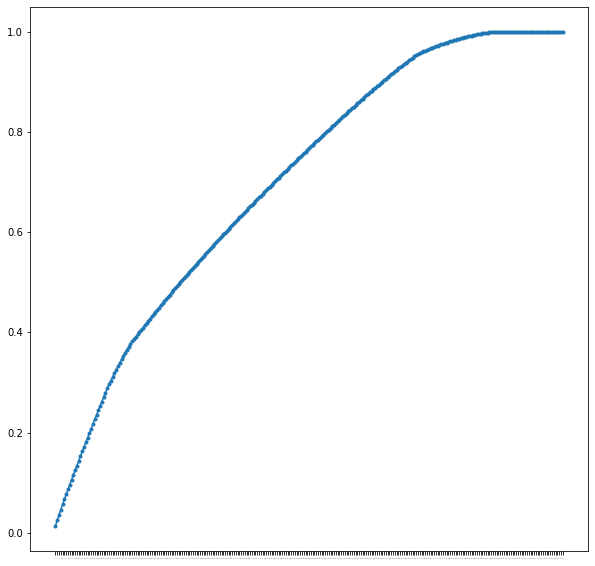

In [177]:
fig, axes = plt.subplots(figsize = (10, 10))
plt.plot(range(1, 286), pca.explained_variance_ratio_.cumsum(), marker = '.')
plt.xticks(ticks=range(1, 286), fontsize = 1);

In [178]:
pca_transformer = make_pipeline(scaler, PCA(n_components = .95))
#Chose .95 because 95% of the variance is explained and looking at the graph excludes many points that are relatively
#insignificant in increasing the overall variance

In [180]:
linreg = LinearRegression()
linreg_pipe = make_pipeline(pca_transformer, linreg)
linreg_pipe.fit(X_train_processed, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('standardscaler', StandardScaler()),
                                 ('pca', PCA(n_components=0.95))])),
                ('linearregression', LinearRegression())])

In [181]:
train_pred_lin = linreg_pipe.predict(X_train_processed)
test_pred_lin = linreg_pipe.predict(X_test_processed)

In [189]:
print(f"Model Training MAE: {mean_absolute_error(y_train, train_pred_lin):.3f}")
print(f"Model Testing MAE: {mean_absolute_error(y_test, test_pred_lin):.3f}")
print(f"Model Training RMSE: {np.sqrt(mean_squared_error(y_train, train_pred_lin)):.3f}")
print(f"Model Testing RMSE: {np.sqrt(mean_squared_error(y_test, test_pred_lin)):.3f}")
print(f"Training R2 Score: {linreg_pipe.score(X_train_processed,y_train):.3f}")
print(f"Test R2 Score: {linreg_pipe.score(X_test_processed,y_test):.3f}")

Model Training MAE: 10.842
Model Testing MAE: 11.064
Model Training RMSE: 13.622
Model Testing RMSE: 13.893
Training R2 Score: 0.101
Test R2 Score: 0.034


The production model I will choose is the linear regression model. For predicting the total score of an NFL game, the error is the most important metric. The linear regression model has both the lowest mean absolute error and root mean squared error.